# Identification of a linear representation of an equilibrium point

In [1]:
# Loading libraries
import os
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.integrate import odeint
from model_aug_koopman import Aug_Koopman_Model, Multi_INT_net, get_initial_condition
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import pickle

file_name_results = 'EQ_Point_dt_01'
output_file_folder = '/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/' + file_name_results +'/'
try:
    os.makedirs(output_file_folder)    
    print("Directory " , output_file_folder ,  " Created ")
except FileExistsError:
    print("Directory " , output_file_folder ,  " already exists, overwriting results")  

Directory  /homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/EQ_Point_dt_01/  already exists, overwriting results


In [2]:
# Non linear system
def Non_linear_linearisable(S,t,mu,sigma):
    x_1 = mu*(S[0]);
    x_2 = sigma*(S[1]-S[0]**2);
    dS  = np.array([x_1,x_2]);
    return dS

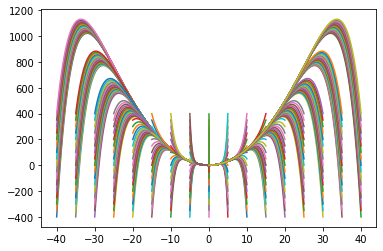

In [3]:
# data
mu =  -1
sigma = -10
dt   = 0.01
Tend = 6

x0 = np.array([[12.0,-1.0]]);
dim = x0.shape[-1]
S_train = []
for i in range(x0.shape[0]):
    S_train.append(odeint(Non_linear_linearisable,x0[i,:],np.arange(0,Tend+0.000001,dt),args=(mu,sigma)));

xi0 = np.arange(-40,41,5)
yi0 = np.arange(-400,410,50)
xv, yv = np.meshgrid(xi0, yi0, sparse=False, indexing='ij')
x0 = np.concatenate((xv.reshape(-1,1),yv.reshape(-1,1)),axis = -1)
dim = x0.shape[-1]
S_test = []
for i in range(x0.shape[0]):
    S_test.append(odeint(Non_linear_linearisable,x0[i,:],np.arange(0,Tend+0.000001,dt),args=(mu,sigma)));

S_train = np.array(S_train)
S_test = np.array(S_test)

for i in range(0,S_test.shape[0]):
    plt.plot(S_test[i,:,0],S_test[i,:,1])

In [4]:
Batch_size = S_train.shape[1]
X_train = S_train[0,:,:]
X_test  = S_test[:,:,:]
nb_Batch   = int(X_train.shape[0]/Batch_size)
X_train = torch.from_numpy(X_train.reshape(nb_Batch,Batch_size,dim)).double()
X_test  = torch.from_numpy(X_test).double()

In [5]:
# NN parameters
dim_aug = 3
dim = 2
params = {}
params['description']='Non_linear_linearisable_Aug_koopman model with dim_'+str(dim_aug+dim)
params['dim_input']=dim
params['dim_output']=dim_aug
params['dt_integration'] = dt
params['nb_Batch'] = nb_Batch
params['ntrain']=[2000,1]
params['dim_latent'] = dim_aug-dim
params['Imag_Eigen'] = False
params['Batch_size'] = Batch_size

In [6]:
# Learning parameters
params_learn = {}
params_learn['train_dir']  = '/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/'
params_learn['train_repo'] = params['description']
params_learn['lr']         = .9 
params_learn['len_seq_pred'] = 300
params_learn['Pretrained']  = False 


In [7]:
# model instantiation
model  = Aug_Koopman_Model(params)
model_Multi_RINN = Multi_INT_net(params,model)
criterion = torch.nn.MSELoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(model.parameters(),lr = params_learn['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor = 0.9, patience=25, verbose=True, min_lr = 0.001)

In [ ]:
# Learning loop
if params_learn['Pretrained']:
    model.load_state_dict(torch.load(output_file_folder + file_name_results + '.pt'))
else:
    for t in range(params['ntrain'][0]):
        for b in range(nb_Batch):
                inp_conc = torch.cat((X_train[b,:,:],model.y_aug[b,:,:]),dim = -1)
                pred, grad, phi = model(inp_conc,params['dt_integration'],0.0)[:3]
                preds, error1, error_aug = [pred], [criterion(pred[:-1,:], inp_conc[1:,:])], [criterion(pred[:-1,dim:], inp_conc[1:,dim:])]
                for i in range(1,20,2):
                    pred, grad, phi = model(inp_conc,params['dt_integration']*i,0.0)[:3]
                    preds, error2 = [pred], criterion(pred[::i,:][:-1,:], inp_conc[::i,:][1:,:])#, [criterion(pred[::2,:][:-1,dim:], inp_conc[1:,dim:])]
                    error1.append(error2)
                loss = torch.stack(error1).sum() #+ 1000*torch.stack(error_aug).mean()
                loss = loss
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                for param_group in optimizer.param_groups:
                    print(param_group['lr'],t,b,loss) 
                optimizer.step()
        scheduler.step(loss)
    torch.save(model.state_dict(), output_file_folder + file_name_results + '.pt')

# Testing the AugKoopman model

In [9]:
# Forecast training set
y_pred_train = np.zeros((X_test.shape[0],X_test.shape[1],dim_aug))
for j in range(X_train.shape[0]):
    inp_conc = torch.cat((X_train[j,:,:],model.y_aug[j,:,:]),dim = -1)
    tmp = inp_conc[:1,:].clone()
    y_pred_train[j,0,:] = tmp.data.numpy()
    for i in range(1,y_pred_train.shape[1]):
        y_pred_train[j,i,:] = model(tmp,params['dt_integration'],0.0)[0].cpu().data.numpy()
        tmp = (torch.from_numpy(np.reshape(y_pred_train[j,i,:],(1,dim_aug))).double())

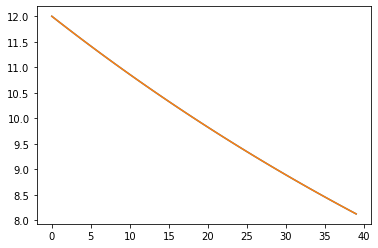

In [10]:
plt.plot(y_pred_train[0,:40,0])
plt.plot(X_train[0,:40,0])


In [11]:
# Forecast test set
y_pred_test_init = np.zeros((X_test.shape[0],X_test.shape[1],dim_aug))
for j in range(X_test.shape[0]):
    tmp = inp_conc[:1,:].clone()
    tmp[:,:2] = (X_test[j,:1,:])
    y_pred_test_init[j,0,:] = tmp.data.numpy()
    for i in range(1,y_pred_test_init.shape[1]):
        y_pred_test_init[j,i,:] = model(tmp,params['dt_integration'],0.0)[0].cpu().data.numpy()
        tmp = (torch.from_numpy(np.reshape(y_pred_test_init[j,i,:],(1,dim_aug))).double())

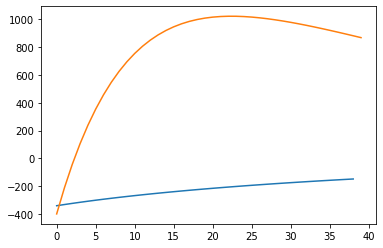

In [12]:
plt.plot(y_pred_test_init[1,1:40,1])
plt.plot(X_test[0,:40,1])

# Learning initial conditions of the augmented states

In [ ]:
for p in model.parameters():
    p.requires_grad = False
y_pred_test_Opti = np.zeros((X_test.shape[0],X_test.shape[1],dim_aug))
for j in range(X_test.shape[0]):
    tmpp,idx, tmp = get_initial_condition(model_Multi_RINN, X_test[j,:3,:], X_train, params['dt_integration'], get_init_in_train_set = False)
    y_pred_test_Opti[j,0,:] = tmp.data.numpy()
    for i in range(1,y_pred_test_Opti.shape[1]):
        y_pred_test_Opti[j,i,:] = model(tmp,params['dt_integration'],0.0)[0].cpu().data.numpy()
        tmp = (torch.from_numpy(np.reshape(y_pred_test_Opti[j,i,:],(1,dim_aug))).double())

# Save simulations

In [15]:
out_res = {}
out_res['train_data'] = X_train.detach().numpy() 
out_res['test_data'] = X_test.detach().numpy()
out_res['dt']  =dt
out_res['infered_train'] = y_pred_train
out_res['infered_test']  =y_pred_test_init
out_res['infered_test_learned_init'] = y_pred_test_Opti

pickle_out = open(output_file_folder+file_name_results+".pkl","wb")
pickle.dump(out_res, pickle_out)
pickle_out.close()

# Load file and plot non linear and linearized trajectories

In [16]:
file_to_read = open(output_file_folder+file_name_results+".pkl", "rb")
res = pickle.load(file_to_read)

In [ ]:
Lin_dyns = model.A.detach().numpy()
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

figure = plt.figure(figsize=(50,50))
ax = figure.gca(projection='3d')
threshholded_pred = res['infered_test_learned_init']
threshholded_test = res['test_data']
cmap = plt.get_cmap('jet')

#threshholded_pred[np.where(np.abs(res['infered_test_learned_init'])>5)] = np.nan
for i in range(threshholded_pred.shape[0]):
    color = cmap(float(i+20)/300)
    ax.plot(threshholded_pred[i,1:,0][::2],threshholded_pred[i,1:,1][::2],threshholded_pred[i,1:,2][::2],"D",markersize=25,c = color)
    #ax.plot(threshholded_pred[i,:,0],threshholded_pred[i,:,1],np.zeros_like(threshholded_pred[i,:,2]),'*',lw = 10)
    ax.plot(threshholded_test[i,:,0][::2],threshholded_test[i,:,1][::2],np.zeros_like(threshholded_test[i,:,0][::2]),c = color,lw = 5)
ax.plot(threshholded_pred[i,1:,0][::2]*np.nan,threshholded_pred[i,1:,1][::2]*np.nan,threshholded_pred[i,1:,2][::2]*np.nan,"D",markersize=50,c = cmap(float(0+20)/300),label = 'Proposed Koopman model')
ax.plot(threshholded_test[i,:,0][::2]*np.nan,threshholded_test[i,:,1][::2]*np.nan,np.zeros_like(threshholded_test[i,:,0][::2]*np.nan),c = cmap(float(0+20)/300),lw = 10,label = 'Non linear Dynamics')
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))

plt.legend()
ax.set_xlabel('$\mathrm{z}_{1,t}$',labelpad = 200)
ax.set_ylabel('$\mathrm{z}_{1,t}$',labelpad = 200)
ax.set_zlabel('$\mathrm{y}_{1,t}$',labelpad = 200)
ax.view_init(45, 70)
#plt.xlabel('$\dot{\mathrm{z}}_{1,t}$',labelpad = 40)
#plt.ylabel('$\dot{\mathrm{z}}_{2,t}$')


In [ ]:
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
cmap = plt.get_cmap('jet')
fig=plt.figure(figsize=(50,50))
for i in range(0,threshholded_pred.shape[0],2):
    color = cmap(float(i+20)/300)
    plt.plot(threshholded_pred[i,1:,0],threshholded_pred[i,1:,1],"D",markersize=25,c = color)
    plt.plot(threshholded_test[i,:,0],threshholded_test[i,:,1],c = color,lw = 8)
plt.plot(threshholded_pred[i,1:,0]*np.nan,threshholded_pred[i,1:,1]*np.nan,"D",markersize=25,c = cmap(float(0+20)/300),label = 'Proposed Koopman model')
plt.plot(threshholded_test[i,:,0]*np.nan,threshholded_test[i,:,1]*np.nan,c = cmap(float(0+20)/300),lw = 8,label = 'Non linear Dynamics')
plt.legend()
plt.xlabel('${\mathrm{z}}_{1,t}$',labelpad = 40)
plt.ylabel('${\mathrm{z}}_{2,t}$')